In [ ]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import json
import re

In [ ]:
file_path = 'suicide_articless.xlsx'
df = pd.read_excel(file_path)

nrc_file_path = 'Italian-NRC-EmoLex.xlsx'
nrc_df = pd.read_excel(nrc_file_path)
emotion_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust'] #emotion columns as found in the NRC emotion lexicon
nrc_df_filtered = nrc_df[(nrc_df[emotion_columns].sum(axis=1) > 0)] #includiamo solo le righe > 0 (quindi con parole mappate con valenza emotiva)
nrc_emotions = nrc_df_filtered.set_index('Italian_Word')[emotion_columns].T.to_dict() #creiamo un dizionario, dove ogni parola è una key e il valore è un dizionario delle emozioni associato
def calculate_emotional_word_percentage(tokens):
    emotional_count = sum(1 for word in tokens if word in nrc_emotions)
    return (emotional_count / len(tokens)) * 100 if len(tokens) > 0 else 0

Exception ignored in: <function ZipFile.__del__ at 0x788f59ba28c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/zipfile.py", line 1834, in __del__
    self.close()
  File "/usr/lib/python3.10/zipfile.py", line 1851, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file
Exception ignored in: <function ZipFile.__del__ at 0x788f59ba28c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/zipfile.py", line 1834, in __del__
    self.close()
  File "/usr/lib/python3.10/zipfile.py", line 1851, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file
<ipython-input-38-9814a6be5281>:10: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  nrc_emotions = nrc_df_filtered.set_index('Italian_Word')[emotion_columns].T.to_dict()


In [ ]:
#Preprocessing
!python -m spacy download it_core_news_sm
nlp = spacy.load("it_core_news_sm")

def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    tokens = [token for token in tokens if not re.fullmatch(r"\b(il|si)\b", token)] #togliamo manualmente i token "il" e "si" altrimenti mantenuti nel dataset
    return tokens

non_empty_text = df['Text'].dropna() #prendiamo i valori non vuoti, processiamo ogni valore e combiniamo il risultato in token
preprocessed_text = []
for text in non_empty_text:
    tokens = process_text(text)
    Processed_text = ' '.join(tokens)
    # Aggiungi il testo processato alla lista
    preprocessed_text.append(Processed_text)

processed_texts = df['Processed_Text']

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 24.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
#NER
def extract_named_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities
df['Named_Entities'] = df['Processed_Text'].apply(extract_named_entities)


IndentationError: unexpected indent (<ipython-input-1-c748e345ffcc>, line 2)

In [ ]:
#Analisi metriche lessicali
num_tokens = []
unique_tokens = []
hapax_legomena = []
emotion_counts = {emotion: [] for emotion in emotion_columns}
emotional_word_percentages = []

for text in processed_texts:
    tokens = text.split()
    num_tokens.append(len(tokens))
    unique_tokens.append(len(set(tokens)))
    hapax_legomena.append(sum(1 for word, count in Counter(tokens).items() if count == 1))
    for emotion in emotion_columns:
      emotion_counts[emotion].append(sum(1 for word in tokens if word in nrc_emotions and nrc_emotions[word].get(emotion, 0) > 0)) #per ogni emozione calcola quante parole in tokens sono associate a quella emozione nel dizionario creato sopra, e aggiunge il conteggio alla lista di conteggio di parole emotive

emotional_word_percentages.append(calculate_emotional_word_percentage(tokens))

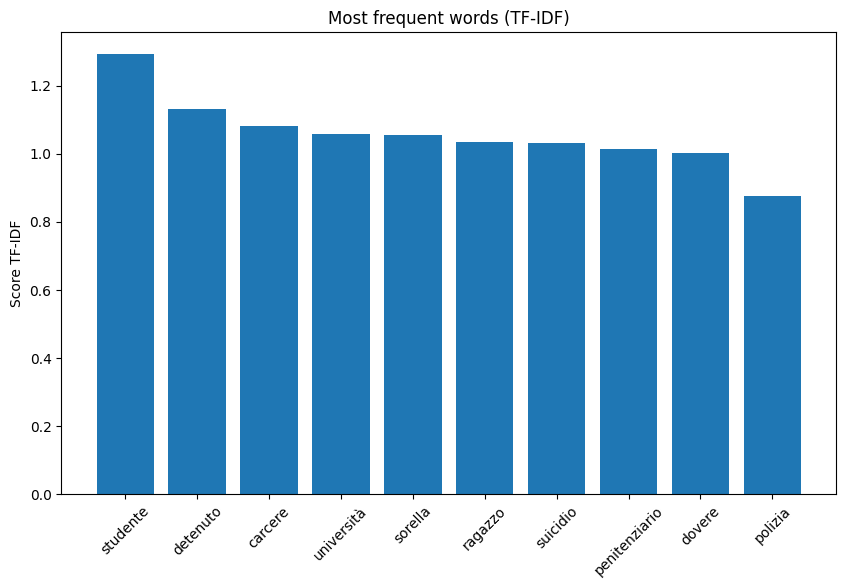

In [ ]:
#Analisi TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(processed_texts)
feature_names = vectorizer.get_feature_names_out()

#Keywords
sum_tfidf = tfidf_matrix.sum(axis=0).A1
tfidf_scores = {feature_names[i]: sum_tfidf[i] for i in range(len(feature_names)) if feature_names[i] != "si"}
most_frequent_words = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:10]

#Visualizzazione
general_freq_df = pd.DataFrame(most_frequent_words, columns=['Word', 'TF-IDF_Score'])
plt.figure(figsize=(10, 6))
plt.bar(general_freq_df['Word'], general_freq_df['TF-IDF_Score'])
plt.title("Most frequent words (TF-IDF)")
plt.xticks(rotation=45)
plt.ylabel("Score TF-IDF")
plt.show()

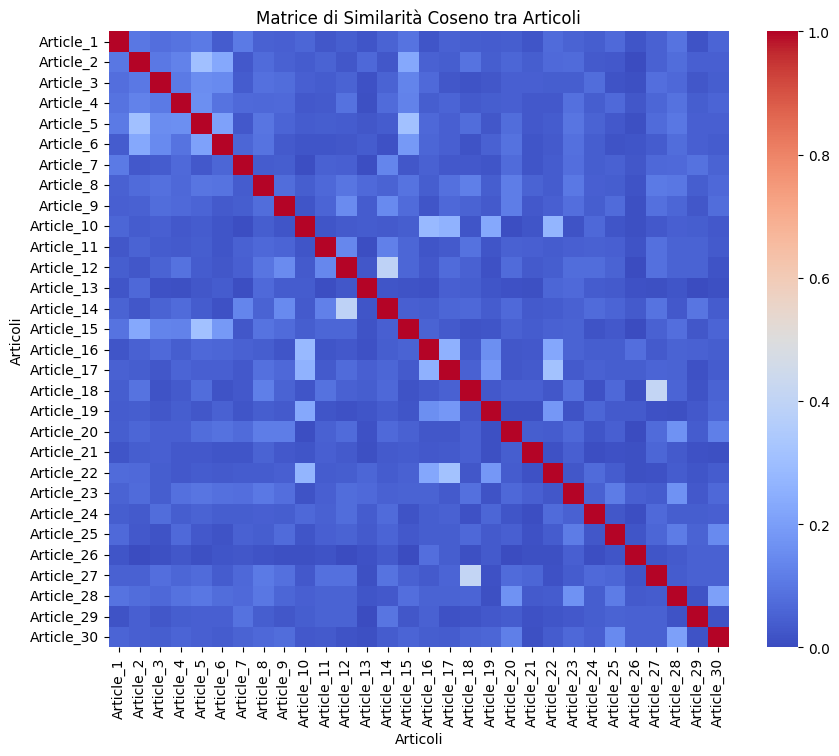

In [ ]:
#Cosine similarity tra articoli e heatmap
similarity_matrix = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(similarity_matrix, columns=[f'Article_{i+1}' for i in range(len(df))],
                             index=[f'Article_{i+1}' for i in range(len(df))])
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=False, cmap="coolwarm", cbar=True)
plt.title("Cosine similarity between articles")
plt.xlabel("Articoli")
plt.ylabel("Articoli")
plt.show()


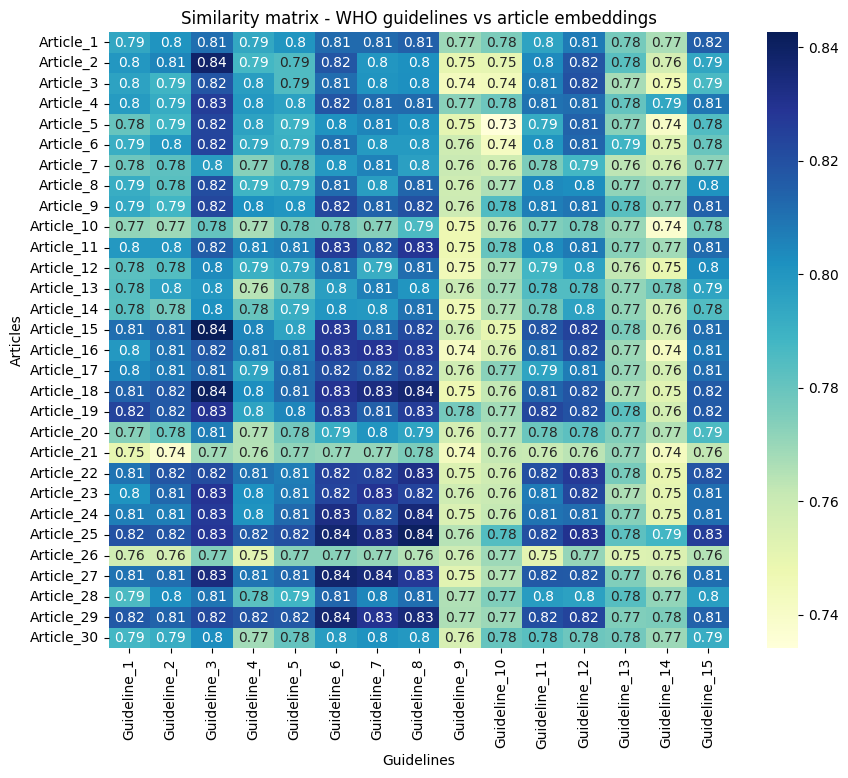


I risultati sono stati salvati in: suicide_analysis_results_gpt.xlsx


In [ ]:
#Analisi degli embeddings (GPT)
openai.api_key = "key"

def get_embedding(text, model="text-embedding-ada-002"):
    response = openai.embeddings.create(model=model, input=text)
    return openai.embeddings.create(input = [text], model=model).data[0].embedding

article_embeddings = [get_embedding(text) for text in processed_texts]

#linee guida in italiano
who_guidelines = [
    "Fornisci informazioni accurate su dove cercare aiuto per pensieri suicidi e crisi.",
    "Educa il pubblico sui fatti relativi al suicidio e alla prevenzione del suicidio sulla base di informazioni accurate.",
    "Riporta storie su come affrontare i fattori di stress della vita e/o i pensieri suicidi e l'importanza della ricerca di aiuto.",
    "Non rendere glamour il suicidio in alcun modo.",
    "Presta particolare attenzione nel reportage dei suicidi di celebrità.",
    "Usa cautela quando si intervistano familiari o amici in lutto o persone che fatto esperienza di suicidio.",
    "Riconosci che gli stessi professionisti dei media potrebbero essere colpiti quando raccontano storie di suicidio.",
    "Non posizionare i contenuti relativi al suicidio come notizia principale e non ripetere indebitamente tali storie.",
    "Non descrivere il metodo utilizzato.",
    "Non nominare né fornire dettagli sul sito/ubicazione.",
    "Non utilizzare linguaggio/contenuti che sensazionalizzano, romanticizzano o normalizzano il suicidio, o che lo presentano come una soluzione pratica ai problemi.",
    "Non semplificare eccessivamente il motivo di un suicidio o ridurlo a un unico fattore.",
    "Non usare un linguaggio sensazionalistico nei titoli.",
    "Non utilizzare fotografie, riprese video, registrazioni audio o collegamenti digitali o a social media.",
    "Non riportare i dettagli delle lettere di suicidio."
]


guideline_embeddings = [get_embedding(guideline) for guideline in who_guidelines]
similarity_matrix_gpt = cosine_similarity(article_embeddings, guideline_embeddings)
similarity_df_gpt = pd.DataFrame(similarity_matrix_gpt, columns=[f'Guideline_{i+1}' for i in range(len(who_guidelines))],
                                  index=[f'Article_{i+1}' for i in range(len(df))])
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df_gpt, annot=True, cmap="YlGnBu", cbar=True)
plt.title("Similarity matrix - WHO guidelines vs article embeddings")
plt.xlabel("Guidelines")
plt.ylabel("Articles")
plt.show()

#xlsx dei risultati
output_file = 'suicide_analysis_results_gpt.xlsx'
with pd.ExcelWriter(output_file) as writer:
    df.to_excel(writer, sheet_name='Linguistic Analysis', index=False)
    general_freq_df.to_excel(writer, sheet_name='TF-IDF', index=False)
    similarity_df.to_excel(writer, sheet_name='Cosine Similarity', index=True)
    similarity_df_gpt.to_excel(writer, sheet_name='GPT Similarity', index=True)
